# Chap5 係り受け解析

In [1]:
import CaboCha
import re
import pydot_ng as pydot
import graphviz

In [2]:
def parse():
    '''
    neko.txt.cabochaを作る
    '''
    with open("./neko.txt") as f:
        with open("./neko.txt.cabocha","w") as outFile:
            cabocha = CaboCha.Parser()
            for line in f:
                outFile.write(cabocha.parse(line).toString(CaboCha.FORMAT_LATTICE))
            

In [3]:
! head -n 10 ./neko.txt.cabocha

* 0 -1D 0/0 0.000000
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
* 0 2D 0/0 -0.764522
　	記号,空白,*,*,*,*,　,　,　
* 1 2D 0/1 -0.764522
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 2 -1D 0/2 0.000000


# 40 係り受け解析結果の読み込み

In [4]:
class Morph:
    '''
    形態素を表すクラス
    surface:表層系
    base:基本形
    pos:品詞
    po1:品詞再分類
    '''
    def __init__(self,surface,base,pos,pos1):
        self.surface=surface
        self.base=base
        self.pos=pos
        self.pos1=pos1
    
    def __str__(self):
        '''オブジェクトの文字列表現'''
        return "surface:{},base:{},pos:{},pos1:{}".format(self.surface,self.base,self.pos,self.pos1)
    


表層形 （Tab区切り）
品詞、品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音

In [5]:
def morph_lines():
    '''
    係り受け解析結果のジェネレータ
    '''
    with open("./neko.txt.cabocha") as file:
        morphs=[]
        for line in file:
            #文の終わりに、一文の形態素解析結果を yield
            if line=="EOS\n":
                if len(morphs)>0:
                    yield morphs
                    morphs=[]
            else:
                if line[0]=='*':
                    #解析結果のかかり先とかの情報。これは、結果に加えない。
                    continue
                else:
                    cols = line.split('\t')
                    res_cols=cols[1].split(',')
                    new_morph=Morph(cols[0],res_cols[6],res_cols[0],res_cols[1])
                    morphs.append(
                       new_morph
                    )

In [6]:
for i,morphs in enumerate(morph_lines()):
    if i==3:
        print("{}文め".format(i))
        for morph in morphs:
            print(morph)
            
        break

3文め
surface:　,base:　,pos:記号,pos1:空白
surface:どこ,base:どこ,pos:名詞,pos1:代名詞
surface:で,base:で,pos:助詞,pos1:格助詞
surface:生れ,base:生れる,pos:動詞,pos1:自立
surface:た,base:た,pos:助動詞,pos1:*
surface:か,base:か,pos:助詞,pos1:副助詞／並立助詞／終助詞
surface:とんと,base:とんと,pos:副詞,pos1:一般
surface:見当,base:見当,pos:名詞,pos1:サ変接続
surface:が,base:が,pos:助詞,pos1:格助詞
surface:つか,base:つく,pos:動詞,pos1:自立
surface:ぬ,base:ぬ,pos:助動詞,pos1:*
surface:。,base:。,pos:記号,pos1:句点


# 41 Chunk　クラスの実装

In [7]:
class Chunk:
    '''
    文節を表す
    morphs:Morphのlist
    dst: かかり先文節のインデックス番号
    srcs:かかり元文節のインデックス番号のlist
    
    functions:
    
    remove_punctuation: 記号を取り除く
    contain_pos_in_morph(pos): posを含むかをみる-> bool
    '''
    def __init__(self):
        self.morphs=[]
        self.srcs=[]
        self.dst=-1
    
    def __str__(self):      
        surface = ''
        for morph in self.morphs:
            surface += morph.surface
        return 'surface:{}\tsrcs:{}\tdst:[{}]'.format(surface, self.srcs, self.dst)
    
    def remove_punctuation(self)->str:
        '''
        記号を取り除く'''
        ret=''
        for morph in self.morphs:
            if morph.pos != '記号':
                ret += morph.surface
        return ret
    
    def contain_pos_in_morphs(self,searchPos)->bool:
        '''
        chunkのなかにseachPos(品詞名)を含むか
        ret:bool
        '''        
        for morph in self.morphs:
            if morph.pos==searchPos:
                return True
        return False
    
    def get_pos_in_morphs(self,pos)->list:
        '''
        morphsにposを含むchunkのlistをreturn'''
        return [res for res in self.morphs if res.pos==pos]
        
    def get_kaku_frame(self)->list:
        '''
        助詞の格パターンとこうをreturn
        '''
        for m in reversed(self.morphs):
            if m.pos=="助詞": 
                return [m.base,self.remove_punctuation()]
        

        
    def get_sahen_wo(self)->list:
        '''
        [さ変接続名詞+を]を含む場合は、surfaceを返す
        '''
        for m1,m2 in zip(reversed(self.morphs[:-1]),reversed(self.morphs)):
            if m1.pos=="名詞" and m1.pos1=="サ変接続":
                if m2.pos=="助詞" and m2.surface=="を":
                    return [m2.base,self.remove_punctuation()]
                
    def mask_noun(self,char)->str:
        '''
        一番最初の名詞をcharに置き換えてstrで返す'''
        ret=""
        replaced=False
        for m in self.morphs:
            if (not replaced) and m.pos=="名詞":
                ret+=char
                replaced=True
            elif m.pos=="記号":
                continue
            else:
                ret+=m.surface
        return ret

\*で始まる行  
* \* 文節番号 係り先の文節番号(係り先なし:-1) 主辞の形態素番号/機能語の形態素番号 係り関係のスコア(大きい方が係りやすい)


In [8]:
def chunk_lines():
    '''
    係り受け解析
    '''
    with open("./neko.txt.cabocha") as file:
        chunks=dict() #すでにでてきた、文節番号
        idx=-1 #文節番号
        
        for line in file:
            if line=="EOS\n": #一文づつの解析ー>一文の終わりでreturn
                if len(chunks)>0:
                    #chunksを文節番号順に並べる。
                    sorted_tuple = sorted(chunks.items(),key=lambda x:x[0])
                    ret=[]
                    for chunk in sorted_tuple:
                        ret.append(chunk[1])
                    yield ret
                    chunks.clear()
                
            elif line[0]=="*":#係り受けの情報
                cols=line.split(' ')
                idx=int(cols[1])
                dst_reg = re.search(r'(.*?)D',cols[2])  #(num)Dのnumがかかり先dst
                dst = int(dst_reg.group(1))
                
                if idx not in chunks:
                    chunks[idx]=Chunk()
                chunks[idx].dst=dst
                
                if dst != -1:
                    if dst not in chunks:
                        chunks[dst]=Chunk()
                    chunks[dst].srcs.append(idx)
            else:#morphの情報
                cols = line.split("\t")
                res_cols=cols[1].split(",")
                
                chunks[idx].morphs.append(
                    Morph(
                        cols[0],
                        res_cols[6],
                        res_cols[0],
                        res_cols[1])
                )

In [9]:
for i,chunks in enumerate(chunk_lines()):
    if i==8:
        for j,chunk in enumerate(chunks):
            print("chunk {}".format(j))
            print(chunk)
        break

chunk 0
surface:しかし	srcs:[]	dst:[9]
chunk 1
surface:その	srcs:[]	dst:[2]
chunk 2
surface:当時は	srcs:[1]	dst:[5]
chunk 3
surface:何という	srcs:[]	dst:[4]
chunk 4
surface:考も	srcs:[3]	dst:[5]
chunk 5
surface:なかったから	srcs:[2, 4]	dst:[9]
chunk 6
surface:別段	srcs:[]	dst:[7]
chunk 7
surface:恐し	srcs:[6]	dst:[9]
chunk 8
surface:いとも	srcs:[]	dst:[9]
chunk 9
surface:思わなかった。	srcs:[0, 5, 7, 8]	dst:[-1]


# 42 かかり元とかかり先の文節の表示

In [10]:
for _,chunks in zip(range(10),chunk_lines()):
    for chunk in chunks:
        if chunk.dst != -1:#chunkのかかり先がある場合
            src_str = chunk.remove_punctuation()
            dst_str = chunks[chunk.dst].remove_punctuation()
            if src_str != '' and dst_str != '':
                print("{}\t{}".format(src_str,dst_str))

吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	種族であったそうだ
あとで	聞くと
聞くと	種族であったそうだ
それは	種族であったそうだ
書生という	人間中で
人間中で	種族であったそうだ
一番	獰悪な
獰悪な	種族であったそうだ
この	書生というのは
書生というのは	話である
時々	捕えて
我々を	捕えて
捕えて	煮て
煮て	食うという
食うという	話である
しかし	思わなかった
その	当時は
当時は	なかったから
何という	考も
考も	なかったから
なかったから	思わなかった
別段	恐し
恐し	思わなかった
いとも	思わなかった
ただ	載せられて
彼の	掌に
掌に	載せられて
載せられて	持ち上げられた
スーと	持ち上げられた
持ち上げられた	時
時	フワフワした
何だか	フワフワした
フワフワした	感じが
感じが	あったばかりである


# 43 名詞を含む文節が動詞を含む文節にかかるもの

In [11]:
for _,chunks in zip(range(10),chunk_lines()):
    for chunk in chunks:
        if chunk.dst != -1:
            src_chunk = chunk
            dst_chunk = chunks[chunk.dst]
            if src_chunk.contain_pos_in_morphs("名詞") and dst_chunk.contain_pos_in_morphs("動詞"):
                src_str=src_chunk.remove_punctuation()
                dst_str= dst_chunk.remove_punctuation()
                if src_str!='':
                    print("n:"+src_str+"\t"+"v:"+dst_str)
            

n:どこで	v:生れたか
n:見当が	v:つかぬ
n:所で	v:泣いて
n:ニャーニャー	v:泣いて
n:いた事だけは	v:記憶している
n:吾輩は	v:見た
n:ここで	v:始めて
n:ものを	v:見た
n:あとで	v:聞くと
n:我々を	v:捕えて
n:掌に	v:載せられて
n:スーと	v:持ち上げられた
n:時	v:フワフワした
n:感じが	v:あったばかりである


# 44 係り受け木の可視化

In [12]:
from graphviz import Digraph
def create_graph(edges):
    graph = Digraph(format='png')
    graph.attr('node',shape='circle')
    
    nodes=set()
    #node の追加
    for src,dst in edges:
        if src[0] not in nodes:
            graph.node(src[0],src[1])
            nodes.add(src[0])
        if dst[0] not in edges:
            graph.node(dst[0],dst[1])
            nodes.add(dst[0])
        
    #edge　の追加
    for src,dst in edges:
        graph.edge(src[0],dst[0])
    graph.render("tree")
            
    

In [13]:
def create_edges(idx):
    '''
    chunkの係関係を、辺の形式でret src->dst'''
    for i,chunks in enumerate(chunk_lines(),1):
        if i==idx:
            edges=[]
            for i,chunk in enumerate(chunks):
                if chunk.dst != -1:
                    src_str = chunk.remove_punctuation()
                    dst_str = chunks[chunk.dst].remove_punctuation()
                    if src_str!='' and dst_str!= '':
                        edges.append([[str(i),src_str],[str(chunk.dst),dst_str]])
        
            return edges
        
    

In [14]:
edges=create_edges(10)

In [15]:
if len(edges)>0:
    graph = create_graph(edges)

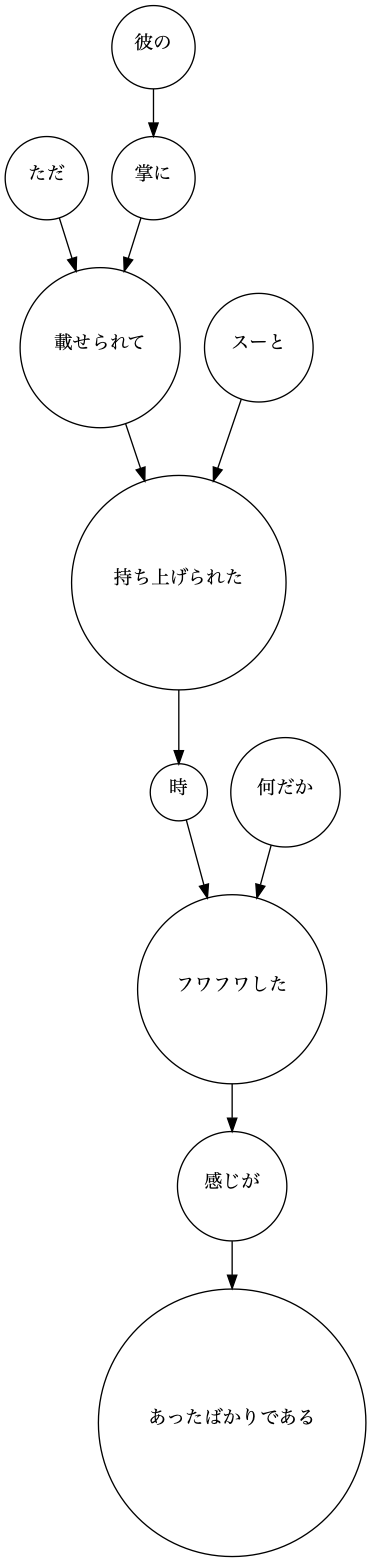

In [16]:
from IPython.display import Image,display_png
display_png(Image('tree.png'))

# 45 動詞の各パターンの抽出

In [17]:
with open("res_45.txt","w") as outFile:
    for chunks in chunk_lines():
        for chunk in chunks:
            chunk_with_verbs= chunk.get_pos_in_morphs("動詞")
            if len(chunk_with_verbs)==0:
                #動詞を含まない
                continue
            #助詞で動詞へかかってるやつ
            particles=[]
            for src in chunk.srcs:
                particles_in_chunk = chunks[src].get_pos_in_morphs("助詞")
                if len(particles_in_chunk)>0:
                    particles.extend(particles_in_chunk)
            verb=chunk_with_verbs[0]
            if len(particles)>0:
                outFile.write("{}\t{}\n".format(verb.base,' '.join(sorted(prt.surface for prt in particles))))
                
            

In [18]:
! head res_45.txt

生れる	で
つく	か が
泣く	で
する	だけ て は
始める	で
見る	は を
聞く	で
捕える	を
煮る	て
食う	て


## Unix　確認

In [19]:
! ls 

chap5.ipynb      res.txt          res_47.txt       result.png
neko.txt         res_45.txt       res_48.txt       tree
neko.txt.cabocha res_46.txt       res_49.txt       tree.png


## 頻出する述語と格パターンの組み合わせ

In [20]:
 ! sort res_45.txt | uniq -c | sort --numeric-sort --reverse | head

 565 云う	と
 442 する	を
 249 思う	と
 199 ある	が
 189 なる	に
 174 する	に
 173 見る	て
 127 する	と
 117 する	が
 105 する	に を
sort: Broken pipe


## する という動詞の格パターン

In [21]:
! grep "^する\s" res_45.txt | sort | uniq -c | sort --numeric-sort --reverse | head

 442 する	を
 174 する	に
 127 する	と
 117 する	が
 105 する	に を
  86 する	て を
  59 する	は
  58 する	て
  57 する	が を
  48 する	から


## 見る　という動詞の格パターン

In [22]:
! grep "^見る\s" res_45.txt | sort | uniq -c | sort --numeric-sort --reverse | head

 173 見る	て
  94 見る	を
  21 見る	て て
  20 見る	から
  18 見る	て を
  14 見る	と
  12 見る	から て
  12 見る	で
  11 見る	て は
   8 見る	に


## 与える　という動詞の格パターンの

In [23]:
! grep "^与える\s" res_45.txt | sort | uniq -c | sort --numeric-sort --reverse | head

   3 与える	に を
   2 与える	て に は を
   1 与える	けれども に は を
   1 与える	だけ で に を
   1 与える	たり て に を
   1 与える	に に対して のみ は は も
   1 与える	か じゃあ て と は を
   1 与える	か として を
   1 与える	が て て と に は は を
   1 与える	て に に は を


# 46 動詞の各フレーム情報の抽出

In [24]:
with open("res_46.txt","w") as outFile:
    for chunks in chunk_lines():
        for chunk in chunks:
            chunk_with_verbs= chunk.get_pos_in_morphs("動詞")
            if len(chunk_with_verbs)==0:
                #動詞を含まない
                continue
            #助詞で動詞へかかってるやつ
            particles=[]
            for src in chunk.srcs:
                #助詞のchunks_list
                if chunks[src].contain_pos_in_morphs("助詞"):
                    src_chunk = chunks[src]
                    ret=src_chunk.get_kaku_frame() #ret->{助詞,chunkのsurface}
                    if ret:
                        particles.append(ret)
                        
            if len(particles)>0:
                particles = sorted(particles,key=lambda x:x[0])
                outFile.write("{}\t[助詞]{}\t[chunk]{}\n".format(chunk_with_verbs[0].base,
                                      ",".join([v[0] for v in particles]),
                                     ",".join([v[1] for v in particles])))

In [25]:
! head -n 10 res_46.txt

生れる	[助詞]で	[chunk]どこで
つく	[助詞]か,が	[chunk]生れたか,見当が
泣く	[助詞]で	[chunk]所で
する	[助詞]て,は	[chunk]泣いて,いた事だけは
始める	[助詞]で	[chunk]ここで
見る	[助詞]は,を	[chunk]吾輩は,ものを
聞く	[助詞]で	[chunk]あとで
捕える	[助詞]を	[chunk]我々を
煮る	[助詞]て	[chunk]捕えて
食う	[助詞]て	[chunk]煮て


# 47 機能動詞構文のマイニング

In [26]:
with open("res_47.txt","w") as outFile:
    for _,chunks in zip(range(10**6),chunk_lines()):
        for chunk in chunks:
            chunk_with_verbs= chunk.get_pos_in_morphs("動詞")
            if len(chunk_with_verbs)==0:
                #動詞を含まない
                continue
            #助詞で動詞へかかってるやつ
            verb = chunk_with_verbs[0]
            particles=[]
            for src in chunk.srcs:
                #助詞のchunks_list
                if chunks[src].contain_pos_in_morphs("助詞"):
                    src_chunk = chunks[src]
                    ret=src_chunk.get_kaku_frame()
                    if ret:
                        particles.append(ret)
                
            #さ変接続動詞を見つける
            sahenwo=[]
            for src in chunk.srcs:
                if chunks[src].contain_pos_in_morphs("助詞"):
                    ret = chunks[src].get_sahen_wo()
                    if ret:
                        sahenwo.append(ret)
                        break# 最左動詞のみ
            if sahenwo:
                for i in range(len(particles)):
                    if particles[i][1]==sahenwo[0][1]:
                        particles.remove(particles[i])
                        break
                    
            if len(particles)>0 and sahenwo:
                particles = sorted(particles,key=lambda x:x[0])
                outFile.write("{}\t[助詞]{}\t[chunk]{}\n".format(sahenwo[0][1]+verb.base,
                                      ",".join([v[0] for v in particles]),
                                     ",".join([v[1] for v in particles])))

In [27]:
! head -n 100 res_47.txt

決心をする	[助詞]と	[chunk]こうと
返報をする	[助詞]んで	[chunk]偸んで
昼寝をする	[助詞]が	[chunk]彼が
迫害を加える	[助詞]て	[chunk]追い廻して
家族的生活をする	[助詞]が,を	[chunk]我等猫族が,愛を
投書をする	[助詞]て,へ	[chunk]やって,ほととぎすへ
話をする	[助詞]に	[chunk]時に
昼寝をする	[助詞]て	[chunk]出て
欠伸をする	[助詞]から,て,て	[chunk]なったから,して,押し出して
報道をする	[助詞]に	[chunk]耳に
御馳走を食う	[助詞]と	[chunk]見ると
雑談をする	[助詞]ながら,は	[chunk]寝転びながら,黒は
呼吸を飲み込む	[助詞]から	[chunk]なってから
思案を定める	[助詞]と,は	[chunk]若くはないと,吾輩は
御馳走をあるく	[助詞]って,て	[chunk]猟って,なって
放蕩をする	[助詞]が	[chunk]ものだからが
放蕩をする	[助詞]も	[chunk]云うよりも
写生を力む	[助詞]に従って	[chunk]忠告に従って
写生をする	[助詞]から	[chunk]しから
対話を聞く	[助詞]で	[chunk]椽側で
半分降参をする	[助詞]と,は	[chunk]相違ないなと,主人は
苦心をする	[助詞]から	[chunk]さっきから
勉強をする	[助詞]たり,て,と	[chunk]開いたり,行列して,見ると
存在を認める	[助詞]から,まで	[chunk]世間から,今まで
談話を聞く	[助詞]が	[chunk]牡蠣的主人が
往来を通る	[助詞]と	[chunk]見ると
決心をする	[助詞]が	[chunk]考え込んでいたが
間食をする	[助詞]で	[chunk]忍んで
我儘をする	[助詞]が	[chunk]他人が
返事をする	[助詞]と	[chunk]利かないのだよと
慰安を求める	[助詞]に	[chunk]遺書に
喧嘩をする	[助詞]で	[chunk]独りで
治療をうける	[助詞]は,も	[chunk]時々は,豪傑でも
位置をする	[助詞]とか,ば	[chunk]癒らぬとか,揉まなければ
挨拶をする	[助詞]から	[chunk]際だから
晩酌を始める	[助詞]から,て	[chunk]今夜から,見えて
遠征をする	[

In [28]:
! cut -f 1 res_47.txt | sort | uniq -c | sort --numeric-sort --reverse | head

  25 返事をする
  19 挨拶をする
  11 話をする
   8 質問をする
   7 喧嘩をする
   6 真似をする
   5 質問をかける
   5 相談をする
   5 昼寝をする
   4 御辞儀をする


In [29]:
 ! sort res_47.txt | uniq -c | sort --numeric-sort --reverse | head 

   2 休養を要する	[助詞]は	[chunk]吾輩はまた
   1 御遠慮なく御批評を願う	[助詞]から	[chunk]稽古ですから
   1 ストライキをしでかす	[助詞]から,て	[chunk]云うから,なって
   1 心的作用を描き出す	[助詞]に	[chunk]ありのままに
   1 通り掃除をはじめる	[助詞]で	[chunk]畳んで
   1 未遂入水をせしめる	[助詞]て	[chunk]して
   1 かような御話を致す	[助詞]が	[chunk]私が
   1 御馳走を食わせる	[助詞]から,て,に	[chunk]してやるから,大事にして,晩に
   1 うんと返事をする	[助詞]から,て,で	[chunk]聞えたから,して,声で
   1 是非御臨席を願う	[助詞]から,も	[chunk]やるつもりだから,先生にも


# 48 名詞から根へのパスの抽出

In [30]:
with open("res_48.txt","w") as out_file:
    for chunks in chunk_lines():
        for chunk in chunks:
            if len(chunk.get_pos_in_morphs('名詞'))>0:
                out_file.write(chunk.remove_punctuation())
                dst = chunk.dst
                while dst != -1:
                    out_file.write(' ->' + chunks[dst].remove_punctuation())
                    dst = chunks[dst].dst
                out_file.write("\n")

In [31]:
! head -n 40 res_48.txt

一
吾輩は ->猫である
猫である
名前は ->無い
どこで ->生れたか ->つかぬ
見当が ->つかぬ
何でも ->薄暗い ->所で ->泣いて ->記憶している
所で ->泣いて ->記憶している
ニャーニャー ->泣いて ->記憶している
いた事だけは ->記憶している
記憶している
吾輩は ->見た
ここで ->始めて ->人間という ->ものを ->見た
人間という ->ものを ->見た
ものを ->見た
あとで ->聞くと ->種族であったそうだ
それは ->種族であったそうだ
書生という ->人間中で ->種族であったそうだ
人間中で ->種族であったそうだ
一番 ->獰悪な ->種族であったそうだ
獰悪な ->種族であったそうだ
種族であったそうだ
書生というのは ->話である
我々を ->捕えて ->煮て ->食うという ->話である
話である
当時は ->なかったから ->思わなかった
何という ->考も ->なかったから ->思わなかった
考も ->なかったから ->思わなかった
彼の ->掌に ->載せられて ->持ち上げられた ->時 ->フワフワした ->感じが ->あったばかりである
掌に ->載せられて ->持ち上げられた ->時 ->フワフワした ->感じが ->あったばかりである
スーと ->持ち上げられた ->時 ->フワフワした ->感じが ->あったばかりである
時 ->フワフワした ->感じが ->あったばかりである
感じが ->あったばかりである
掌の ->上で ->落ちついて ->見たのが ->人間という ->ものの ->見始であろう
上で ->落ちついて ->見たのが ->人間という ->ものの ->見始であろう
書生の ->顔を ->見たのが ->人間という ->ものの ->見始であろう
顔を ->見たのが ->人間という ->ものの ->見始であろう
見たのが ->人間という ->ものの ->見始であろう
人間という ->ものの ->見始であろう
ものの ->見始であろう


# 49 名詞間の係り受けパスの抽出

In [32]:
def isChild(i,j)->bool:
    '''
    return True if i is child of j
    '''
    dst=i
    while dst!=-1:
        if dst==j:
            return True
        else:
            dst = chunks[dst].dst
    return False

In [33]:
def print_path_with_two_mask(i,j):
    '''
    print path from i to j
    mask first and last noud with X,Y
    return None
    insetd,print path to j form i
    '''
    path=""
    dst = chunks[i].dst
    path+=chunks[i].mask_noun("X")
    if i!=j:
        while dst!=j:
            path+=" -> "+ chunks[dst].remove_punctuation()
            dst = chunks[dst].dst

        path+="->"+chunks[dst].mask_noun("Y")
    print(path,end="")
        

In [34]:
def print_path_with_one_mask(i,j,ch="X"):
    '''
    print path from i to j
    first noun will be masked with ch(default X)
    '''
    path=""
    dst = chunks[i].dst
    path+=chunks[i].mask_noun(ch)
    if i!=j:
        while dst!=j:
            path+="->"+ chunks[dst].remove_punctuation()
            dst = chunks[dst].dst
        path+="->"+chunks[dst].remove_punctuation()
    
    print(path,end="")

In [35]:
def calc_lca(i,j)->int:
    '''
    chunk[i],chunk[j]のLCA(least common anscestor)
    を見つける
    そのindexを返す
    '''
    i_parents=set()
    i_dst=chunks[i].dst
  
    while True:
        i_parents.add(dst)
        i_dst=chunks[dst].dst
        if i_dst==-1:
            break
    
    j_dst = chunks[j].dst
  
    while True:
        if j_dst in i_parents:
            return dst
        elif j_dst==-1:
            break
        else:
            j_dst = chunks[dst].dst
   # print("NONE")
    return None
        

In [36]:
with open("res_49.txt","w") as out_file:                    
    for _,chunks in zip(range(10),chunk_lines()):
        print("---------new sentence--------------")
        for i in range(len(chunks)):
            if chunks[i].contain_pos_in_morphs('名詞'):
                for j in range(i+1,len(chunks)):
                    if chunks[j].contain_pos_in_morphs('名詞'):
                        if  isChild(i,j):
                            print_path_with_two_mask(i,j)
                        elif isChild(j,i):
                            print_path_with_two_mask(j,i)
                        else:
                            lca = calc_lca(i,j)
                            for sr in chunks[lca].srcs:
                                if i==sr or isChild(i,sr):
                                    #lcaの一つ前までのpath
                                    print_path_with_one_mask(i,sr,ch="X")
                            
                            print(" | ",end="")
                            
                            for sr in chunks[lca].srcs:
                                if  j == sr or isChild(j,sr):
                                    #lcaの一つ前までのpath
                                    print_path_with_one_mask(j,sr,ch="Y")
                            
                            print(" | ",end="")
                            
                            print(chunks[lca].remove_punctuation(),end="")
                        print()
        print()

---------new sentence--------------

---------new sentence--------------
Xは->Yである

---------new sentence--------------

---------new sentence--------------
Xで->生れたか | Yが | つかぬ

---------new sentence--------------
Xでも -> 薄暗い->Yで
Xでも->薄暗い->所で->泣いて | Y->泣いて | 記憶している
Xでも->薄暗い->所で->泣いて | Yだけは | 記憶している
Xでも -> 薄暗い -> 所で -> 泣いて->Yしている
Xで->泣いて | Y->泣いて | 記憶している
Xで->泣いて | Yだけは | 記憶している
Xで -> 泣いて->Yしている
X->泣いて | Yだけは | 記憶している
X -> 泣いて->Yしている
Xだけは->Yしている

---------new sentence--------------
Xは | Yで->始めて->人間という->ものを | 見た
Xは | Yという->ものを | 見た
Xは | Yを | 見た
Xで -> 始めて->Yという
Xで -> 始めて -> 人間という->Yを
Xという->Yを

---------new sentence--------------
Xで->聞くと | Yは | 種族であったそうだ
Xで->聞くと | Yという->人間中で | 種族であったそうだ
Xで->聞くと | Y中で | 種族であったそうだ
Xで->聞くと | Y->獰悪な | 種族であったそうだ
Xで->聞くと | Yな | 種族であったそうだ
Xで -> 聞くと->Yであったそうだ
Xは | Yという->人間中で | 種族であったそうだ
Xは | Y中で | 種族であったそうだ
Xは | Y->獰悪な | 種族であったそうだ
Xは | Yな | 種族であったそうだ
Xは->Yであったそうだ
Xという->Y中で
Xという->人間中で | Y->獰悪な | 種族であったそうだ
Xという->人間中で | Yな | 種族であったそうだ
Xという -> 人間中で->Yであったそうだ
X中で | Y->獰悪